In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
results_dir = os.path.join(cfg.repo_root,
                           'cross_cancer_flip_labels',
                           'cross_cancer_flip_labels')
flip_labels_df = (
    au.load_flip_labels_results(results_dir, 'flip_labels')
      .sort_values(by=['train_identifier', 'test_identifier',
                       'percent_flip', 'signal'])
)
print(flip_labels_df.shape)
flip_labels_df.head(n=10)

(1050, 9)


,auroc,aupr,train_identifier,test_identifier,signal,seed,data_type,percent_flip,experiment
0,0.93951,0.592760,BRAF_COAD,BRAF_COAD,shuffled,42,train,0.1,flip_labels
1,0.33741,0.007788,BRAF_COAD,BRAF_COAD,shuffled,42,test,0.1,flip_labels
2,0.47181,0.073147,BRAF_COAD,BRAF_COAD,shuffled,42,cv,0.1,flip_labels
0,0.99362,0.924860,BRAF_COAD,BRAF_COAD,signal,42,train,0.1,flip_labels
1,0.93182,0.077713,BRAF_COAD,BRAF_COAD,signal,42,test,0.1,flip_labels
2,0.67531,0.146030,BRAF_COAD,BRAF_COAD,signal,42,cv,0.1,flip_labels
0,1.00000,1.000000,BRAF_COAD,BRAF_COAD,shuffled,42,train,0.2,flip_labels
1,0.50616,0.019433,BRAF_COAD,BRAF_COAD,shuffled,42,test,0.2,flip_labels
2,0.44256,0.059475,BRAF_COAD,BRAF_COAD,shuffled,42,cv,0.2,flip_labels
0,1.00000,1.000000,BRAF_COAD,BRAF_COAD,signal,42,train,0.2,flip_labels


In [3]:
flip_norm_df = au.normalize_to_control(flip_labels_df,
                                       train_id='train_identifier',
                                       test_id='test_identifier',
                                       additional_cols=['percent_flip'])
flip_norm_df = (
    flip_norm_df.assign(gene=lambda x: x.train_identifier.str.split('_', expand=True)[0],
                        cancer_type=lambda x: x.train_identifier.str.split('_', expand=True)[1])
                .drop(columns=['train_identifier', 'test_identifier'])
                .reset_index()
)
flip_norm_df.head()

,index,percent_flip,aupr,gene,cancer_type
0,1,0.1,0.069925,BRAF,COAD
1,1,0.2,0.007246,BRAF,COAD
2,1,0.3,0.015868,BRAF,COAD
3,1,0.5,0.002371,BRAF,COAD
4,1,0.1,0.003728,BRAF,LUAD


Text(0.5, 1.0, 'Percent of labels flipped: 0.3')

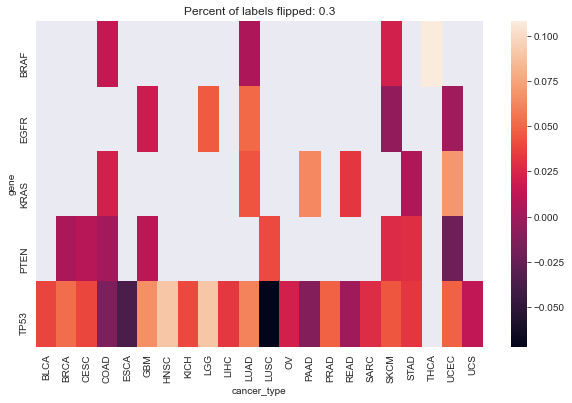

In [4]:
percent_flip = 0.3
heatmap_df = (
    flip_norm_df.query('percent_flip == @percent_flip')
                .pivot(index='gene', columns='cancer_type', values='aupr')
)
sns.set({'figure.figsize': (10, 6)})
sns.heatmap(heatmap_df)
plt.title('Percent of labels flipped: {}'.format(percent_flip))

In [5]:
flip_norm_df['identifier'] = flip_norm_df.gene + '_' + flip_norm_df.cancer_type
flip_norm_df.head()

,index,percent_flip,aupr,gene,cancer_type,identifier
0,1,0.1,0.069925,BRAF,COAD,BRAF_COAD
1,1,0.2,0.007246,BRAF,COAD,BRAF_COAD
2,1,0.3,0.015868,BRAF,COAD,BRAF_COAD
3,1,0.5,0.002371,BRAF,COAD,BRAF_COAD
4,1,0.1,0.003728,BRAF,LUAD,BRAF_LUAD


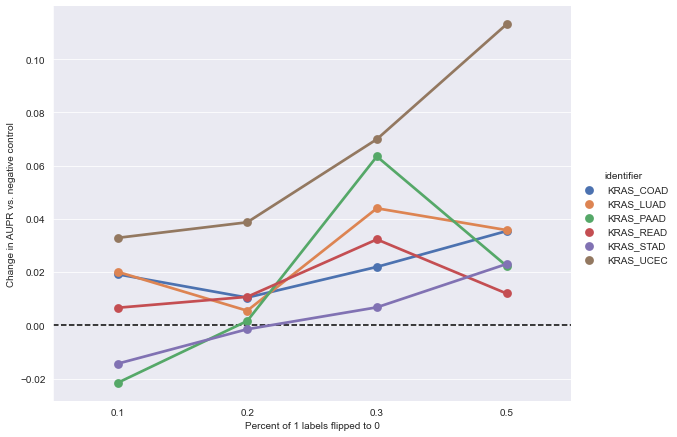

In [6]:
plot_gene = 'KRAS'
plot_df = flip_norm_df[flip_norm_df.gene == plot_gene]
# sns.set doesn't work with catplot
# have to specify width/height using height, aspect args
sns.catplot(data=plot_df, x='percent_flip', y='aupr', hue='identifier',
            kind='point', height=6, aspect=8/6)
plt.xlabel('Percent of 1 labels flipped to 0')
plt.ylabel('Change in AUPR vs. negative control')
plt.axhline(y=0, color='black', linestyle='--')